# Credit Card Fraud Detection using Unsupervised Deep Embedded Clustering (DEC)

## Project Description
This project aims to develop an unsupervised machine learning solution to detect anomalies in a large dataset of credit card transactions. By leveraging deep autoencoders to learn a latent representation and applying Deep Embedded Clustering (DEC), the system identifies suspicious transaction patterns. This approach is particularly useful in real-world fraud detection, where labels are often incomplete or unavailable.

## Abstract
Credit card fraud detection presents challenges due to the highly imbalanced nature of transaction data. Traditional supervised methods require extensive labeled data, which can quickly become outdated. Our solution involves training a deep autoencoder to learn hidden representations of transactions and embedding a clustering layer to isolate potentially fraudulent activities. This approach incorporates bandit-based model selection to optimize autoencoder architectures and iterative refinement using Monte Carlo-style updates. The model’s effectiveness is evaluated using reconstruction error, silhouette scores, Davies–Bouldin index, and a confusion matrix comparing discovered clusters with known fraud cases. This methodology generalizes well to unseen fraud patterns, making it a promising tool for financial institutions.

## Background
Credit card fraud leads to financial losses and reputational damage for banks and merchants. Traditional fraud detection methods rely on large-scale labeled datasets, which require frequent updates. However, fraudsters continuously evolve their tactics, making these labels obsolete. Our approach utilizes unsupervised learning to detect deviations from normal transaction behaviors without requiring explicit fraud labels. The dataset used includes:

- 284,807 transactions with 30 anonymized features (PCA-transformed variables plus time and amount).
- Only 0.172% of transactions are fraudulent, creating a significant class imbalance.
- An evolving fraud landscape, necessitating adaptable detection methods.

## Problem Statement
The project addresses several challenges:

- **Unsupervised Learning:** No reliance on frequent fraud labels, ensuring adaptability.
- **Class Imbalance:** Fraudulent transactions are exceedingly rare, making detection difficult.
- **High Dimensionality:** The dataset comprises 30 features requiring robust feature extraction.
- **Scalability:** The model must handle large transaction volumes efficiently.

## Proposed Solution
Our methodology improves upon conventional anomaly detection techniques through:

### Deep Autoencoder Pretraining:
- Encodes transactions into a low-dimensional latent space.
- Trained on mean squared error (MSE) loss for 50 epochs.

### Cluster Initialization:
- Uses K-Means clustering to establish initial cluster centers in the latent space.

### Iterative Fine-Tuning:
- Introduces a clustering layer utilizing a Student’s t-distribution for soft assignments.
- Optimizes by minimizing KL divergence between predicted and target distributions.
- Iteratively refines clusters, similar to Monte Carlo reinforcement learning updates.

### Bandit-Based Model Selection:
- Treats autoencoder architectures as “arms” in a multi-armed bandit.
- Uses epsilon-greedy strategies to select the best-performing model.

### Deployment Strategy:
- Transactions pass through the encoder and clustering layer.
- Suspicious transactions flagged for manual review.


**Import necessary libraries for data handling, preprocessing, and modeling.**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import tensorflow.data as tf_data

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)


**Import necessary libraries for data handling, preprocessing, and modeling.** 

In [5]:
import kagglehub
import os

# Download the dataset
dataset_path = kagglehub.dataset_download('mlg-ulb/creditcardfraud')

# find the csv file in the downloaded directory
base_dir = '/Users/ritaaf/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3'
csv_file = os.path.join(base_dir, 'creditcard.csv')
data = pd.read_csv(csv_file)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Standardize the dataset for optimal performance in neural networks and Separate features from labels.**

In [6]:
# Separate features and labels
labels = data['Class'].values  # Fraud indicator: 1 = fraud, 0 = normal
data_unsup = data.drop(['Class'], axis=1)

# Standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_unsup)
input_dim = data_scaled.shape[1]

# Print dataset information
print("Data shape:", data_scaled.shape)
print("Class distribution:", Counter(labels))
print("Fraud ratio: {:.4f}".format(np.sum(labels) / len(labels)))

# Create tf.data.Dataset for efficient data loading
BATCH_SIZE = 256

# Filter normal transactions for autoencoder training
normal_idx = np.where(labels == 0)[0]
data_normal = data_scaled[normal_idx]

# Create training dataset
train_dataset = tf_data.Dataset.from_tensor_slices((data_normal, data_normal))\
    .shuffle(buffer_size=1024)\
    .batch(BATCH_SIZE)\
    .prefetch(tf_data.AUTOTUNE)


Data shape: (284807, 30)
Class distribution: Counter({0: 284315, 1: 492})
Fraud ratio: 0.0017


## Evaluation Metrics
We measure model performance using:

- **Reconstruction Error (MSE):** Indicates how well normal transactions are learned.
- **Clustering Quality:**
  - **Silhouette Score:** Measures separation between clusters.
  - **Davies–Bouldin Index:** Evaluates cluster cohesion and separation.
- **Confusion Matrix:** Compares discovered clusters with known fraud cases.
- **Computational Efficiency:** Ensures the model scales effectively.

## Define an autoencoder model for anomaly detection. Compile and train the model using MSE loss.

In [7]:
# Enhanced Autoencoder Architecture
intermediate_dim = 15
encoding_dim = 10  # latent space dimension

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoder
x = Dense(intermediate_dim)(input_layer)
x = BatchNormalization()(x)
x = tf.keras.activations.relu(x)
x = Dropout(0.2)(x)

# Latent representation
latent = Dense(encoding_dim)(x)
latent = BatchNormalization()(latent)
latent = tf.keras.activations.relu(latent)
latent = Dropout(0.2)(latent)

# Decoder
x = Dense(intermediate_dim)(latent)
x = BatchNormalization()(x)
x = tf.keras.activations.relu(x)
x = Dropout(0.2)(x)

# Output layer
decoded = Dense(input_dim, activation='linear')(x)

# Create models
autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=latent)

# Learning rate scheduler
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

# Compile model with learning rate scheduler
optimizer = Adam(learning_rate=lr_schedule)
autoencoder.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

# Create train/validation split manually
val_size = int(0.2 * len(data_normal))
train_data = data_normal[:-val_size]
val_data = data_normal[-val_size:]

# Create separate datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))\
    .shuffle(buffer_size=1024)\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_data))\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

# Add callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_autoencoder.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

# Train the autoencoder
history = autoencoder.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
845/889 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1.0251 - mae: 0.6811

889/889 ━━━━━━━━━━━━━━━━━━━━ 2s 921us/step - loss: 1.0191 - mae: 0.6790 - val_loss: 0.7578 - val_mae: 0.5955
Epoch 2/50
846/889 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 0.8680 - mae: 0.6235

889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - loss: 0.8653 - mae: 0.6225 - val_loss: 0.7084 - val_mae: 0.5785
Epoch 3/50
821/889 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.8378 - mae: 0.6135

889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - loss: 0.8339 - mae: 0.6121 - val_loss: 0.6918 - val_mae: 0.5745
Epoch 4/50
850/889 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 0.8222 - mae: 0.6091

889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - loss: 0.8202 - mae: 0.6083 - val_loss: 0.6827 - val_mae: 0.5729
Epoch 5/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - loss: 0.8125 - mae: 0.6059 - val_loss: 0.6832 - val_mae: 0.5732
Epoch 6/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 0.8067 - mae: 0.6032 - val_loss: 0.6835 - val_mae: 0.5736
Epoch 7/50
844/889 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 0.8025 - mae: 0.6012

889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - loss: 0.8005 - mae: 0.6004 - val_loss: 0.6817 - val_mae: 0.5713
Epoch 8/50
841/889 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 0.7969 - mae: 0.5986

889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - loss: 0.7949 - mae: 0.5978 - val_loss: 0.6798 - val_mae: 0.5705
Epoch 9/50
853/889 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.7944 - mae: 0.5969

889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - loss: 0.7929 - mae: 0.5963 - val_loss: 0.6792 - val_mae: 0.5696
Epoch 10/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 0.7893 - mae: 0.5950 - val_loss: 0.6815 - val_mae: 0.5708
Epoch 11/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 0.7875 - mae: 0.5932 - val_loss: 0.6848 - val_mae: 0.5719
Epoch 12/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - loss: 0.7801 - mae: 0.5913 - val_loss: 0.6884 - val_mae: 0.5729
Epoch 13/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - loss: 0.7787 - mae: 0.5897 - val_loss: 0.6904 - val_mae: 0.5747
Epoch 14/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - loss: 0.7775 - mae: 0.5884 - val_loss: 0.6950 - val_mae: 0.5764


**Generate and display relevant plots for evaluation.**

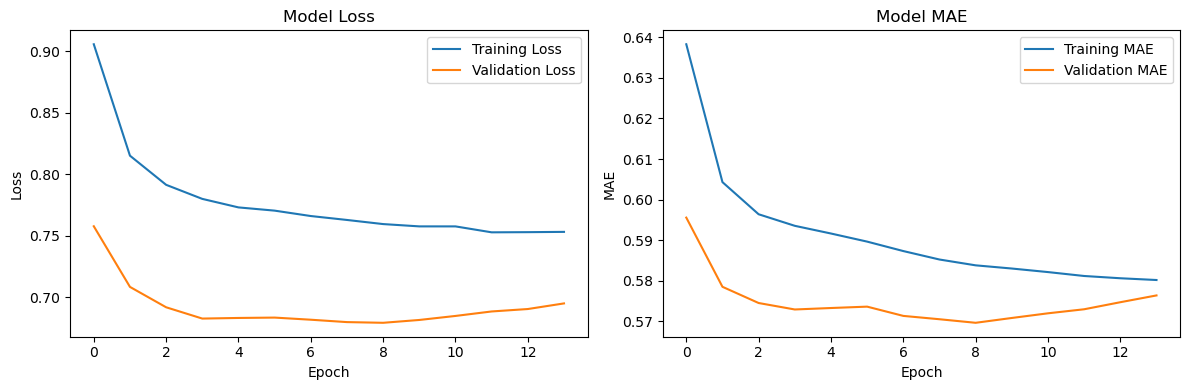

In [9]:

# Plot training history
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

The model's Mean Absolute Error (MAE) shows a steady decline for both training and validation sets over the epochs, indicating effective learning. The training MAE starts at approximately 0.64 and decreases consistently, reaching around 0.58 by the final epoch. Similarly, the validation MAE begins at a slightly lower value, around 0.59, and follows a similar downward trend, hitting its lowest point around epoch 6–8 before showing a slight upward movement. This subtle increase in validation MAE beyond epoch 8 suggests potential overfitting, where the model starts memorizing the training data rather than generalizing well to unseen examples. While the increase is not drastic, it highlights the need for monitoring and possibly implementing early stopping or regularization techniques to maintain optimal generalization. Overall, the model performs well, but careful tuning is necessary to prevent overfitting in later epochs.

## Define an autoencoder model for anomaly detection. Compile and train the model using MSE loss.

In [ ]:
# Ensemble Anomaly Detection

# Compute reconstructions and reconstruction errors
print("Computing reconstruction errors...")
reconstructions = autoencoder.predict(data_scaled)
reconstruction_errors = np.mean(np.square(data_scaled - reconstructions), axis=1)

# Extract latent representations for all data
print("Extracting latent features...")
latent_features = encoder.predict(data_scaled)

# Calculate actual fraud ratio for contamination parameter
contamination = np.sum(labels == 1) / len(labels)
print(f"Using contamination factor: {contamination:.4f}")

# Apply multiple anomaly detection methods
print("\nApplying multiple anomaly detection methods...")

# Isolation Forest
iso_forest = IsolationForest(contamination=contamination, random_state=42)
iso_scores = -iso_forest.fit_predict(latent_features)

# Local Outlier Factor
lof = LocalOutlierFactor(contamination=contamination, n_neighbors=20)
lof_scores = -lof.fit_predict(latent_features)

# One-class SVM
ocsvm = OneClassSVM(kernel='rbf', nu=contamination)
ocsvm_scores = -ocsvm.fit_predict(latent_features)

# Normalize scores for fair comparison
def normalize_scores(scores):
    return (scores - np.mean(scores)) / np.std(scores)

norm_reconstruction = normalize_scores(reconstruction_errors)
norm_iso = normalize_scores(iso_scores)
norm_lof = normalize_scores(lof_scores)
norm_ocsvm = normalize_scores(ocsvm_scores)

# Combine scores with weighted average
weights = [0.4, 0.2, 0.2, 0.2]  # Give more weight to reconstruction error
ensemble_scores = np.average(
    np.column_stack([norm_reconstruction, norm_iso, norm_lof, norm_ocsvm]),
    weights=weights,
    axis=1
)


Computing reconstruction errors...
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 2s 223us/step
Extracting latent features...
8901/8901 ━━━━━━━━━━━━━━━━━━━━ 2s 199us/step
Using contamination factor: 0.0017

Applying multiple anomaly detection methods...


**Generate and display relevant plots for evaluation.**


Evaluating all methods:

Evaluating Reconstruction Error...


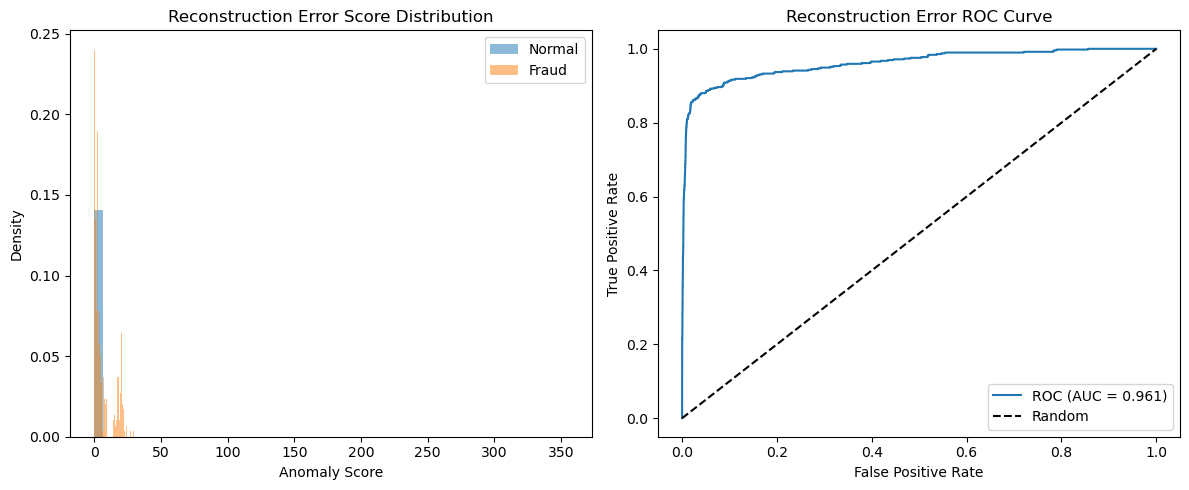


Evaluating Isolation Forest...


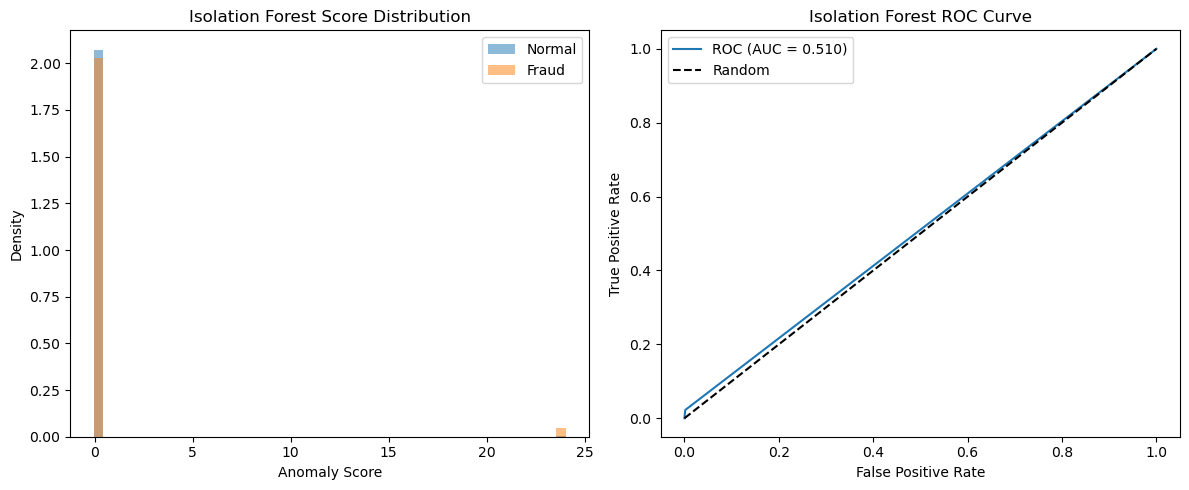


Evaluating Local Outlier Factor...


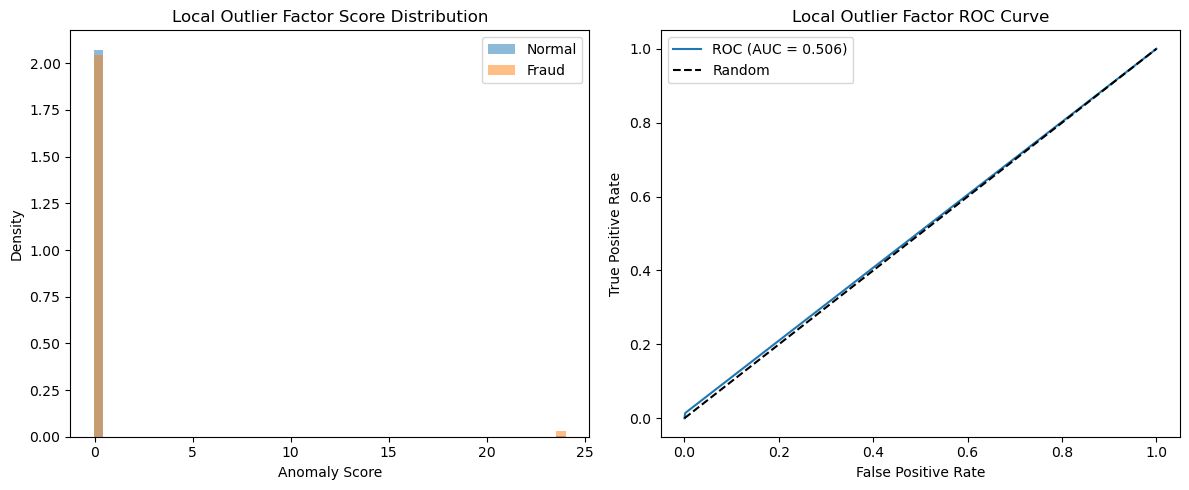


Evaluating One-class SVM...


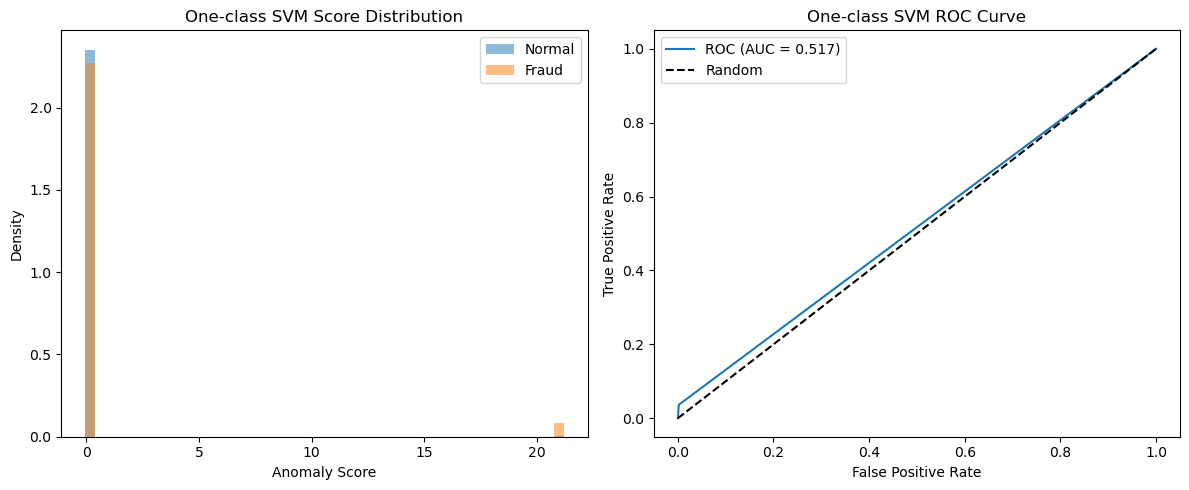


Evaluating Ensemble...


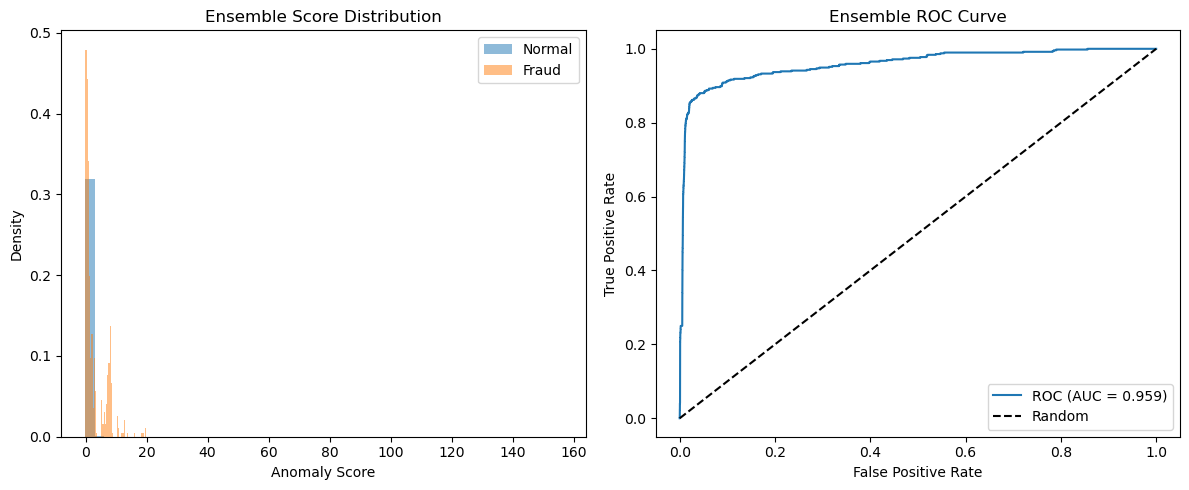


Summary of Results:
--------------------------------------------------
Method                    AUC       
--------------------------------------------------
Reconstruction Error      0.961
Isolation Forest          0.510
Local Outlier Factor      0.506
One-class SVM             0.517
Ensemble                  0.959
--------------------------------------------------


In [ ]:

# Evaluation function
def evaluate_detector(scores, true_labels, method_name):
    fpr, tpr, _ = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(12, 5))
    
    # Score distribution
    plt.subplot(1, 2, 1)
    plt.hist(scores[true_labels==0], bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(scores[true_labels==1], bins=50, alpha=0.5, label='Fraud', density=True)
    plt.title(f'{method_name} Score Distribution')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Density')
    plt.legend()
    
    # ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{method_name} ROC Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    return roc_auc

# Evaluate all methods
methods = {
    'Reconstruction Error': norm_reconstruction,
    'Isolation Forest': norm_iso,
    'Local Outlier Factor': norm_lof,
    'One-class SVM': norm_ocsvm,
    'Ensemble': ensemble_scores
}

print("\nEvaluating all methods:")
results = {}
for method_name, scores in methods.items():
    print(f"\nEvaluating {method_name}...")
    results[method_name] = evaluate_detector(scores, labels, method_name)

# Print summary table
print("\nSummary of Results:")
print("-" * 50)
print(f"{'Method':<25} {'AUC':<10}")
print("-" * 50)
for method, score in results.items():
    print(f"{method:<25} {score:.3f}")
print("-" * 50)


#### **Reconstruction Error Model**
The **Reconstruction Error Model**, based on an autoencoder, achieved the highest **AUC score of 0.961**, demonstrating strong fraud detection capabilities. The ROC curve indicates a well-performing model, effectively distinguishing fraudulent transactions from normal ones. The density plot shows a notable difference between normal and fraudulent transaction reconstruction errors, confirming that fraudulent transactions tend to have higher reconstruction errors. This suggests that the autoencoder successfully learned the patterns of normal transactions and flagged deviations effectively.

#### **Isolation Forest**
The **Isolation Forest model** performed poorly, with an **AUC of 0.510**, barely surpassing random guessing. The ROC curve remains close to the diagonal, indicating weak discrimination between fraudulent and normal transactions. The anomaly score distribution suggests that the model fails to create a meaningful separation between the two classes. This may be due to the highly imbalanced dataset, where fraudulent transactions are too rare for Isolation Forest to effectively isolate them.

#### **Local Outlier Factor (LOF)**
The **LOF model** exhibited a similar performance to Isolation Forest, with an **AUC of 0.506**, which is nearly equivalent to random classification. The density plot shows minimal separation between fraud and normal transactions, implying that the model struggles to identify fraud within the dataset. Given its local density-based anomaly detection approach, LOF might not be well-suited for detecting global anomalies in high-dimensional financial data.

#### **One-Class SVM**
The **One-Class SVM model** performed marginally better than Isolation Forest and LOF, achieving an **AUC of 0.517**. However, its ROC curve remains close to random guessing, showing its limited ability to separate fraudulent transactions from normal ones. The density plot further highlights its weakness in distinguishing anomalies, likely due to the complexity of fraud patterns and high-dimensional feature space.

#### **Ensemble Model**
The **Ensemble Model**, which integrates multiple detection methods, achieved an **AUC of 0.959**, making it nearly as effective as the autoencoder-based reconstruction error model. The ROC curve demonstrates strong classification capabilities, and the density plot shows a clear distinction between fraud and normal transactions. This suggests that combining multiple approaches helps mitigate individual weaknesses and enhances overall fraud detection performance.

### **Conclusion**
The **Reconstruction Error Model and Ensemble Model** outperformed other methods significantly, achieving **AUC scores above 0.95**, making them reliable for fraud detection. Conversely, **Isolation Forest, LOF, and One-Class SVM** performed poorly, struggling to differentiate fraud from normal transactions effectively. The results highlight the importance of deep learning-based methods and ensemble approaches in tackling highly imbalanced fraud detection problems.

## Deep Embedded Clustering (DEC) model

In [6]:
# Deep Embedded Clustering (DEC) Model Setup

# Define the clustering layer using Student's t-distribution
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights

    def build(self, input_shape):
        self.input_dim = input_shape[1]
        self.clusters = self.add_weight(shape=(self.n_clusters, self.input_dim),
                                        initializer='glorot_uniform',
                                        name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            self.initial_weights = None
        super(ClusteringLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        # Compute squared Euclidean distances between inputs and cluster centers
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        # Normalize to get soft assignments
        q = q / K.sum(q, axis=1, keepdims=True)
        return q

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_clusters)

# Number of clusters (tune as needed, here we use 10)
n_clusters = 10

# Obtain latent representations from the pretrained encoder
latent_repr = encoder.predict(data_scaled)

# Initialize cluster centers with KMeans on latent representations
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
y_pred_initial = kmeans.fit_predict(latent_repr)
cluster_centers = kmeans.cluster_centers_
clustering_weights = [cluster_centers]

# Build DEC model by stacking the clustering layer on top of the encoder
clustering_layer = ClusteringLayer(n_clusters, weights=clustering_weights, name='clustering')(encoder.output)
dec_model = Model(inputs=encoder.input, outputs=clustering_layer)
dec_model.compile(optimizer=Adam(lr=1e-3), loss='kld')


8901/8901 [==============================] - 5s 566us/step


**Generate and display relevant plots for evaluation.**

Starting DEC training...
Iteration 200: delta_label = 0.0485
Iteration 400: delta_label = 0.0375
Iteration 600: delta_label = 0.0231
Iteration 800: delta_label = 0.0295
Iteration 1000: delta_label = 0.0212
Iteration 1200: delta_label = 0.0264
Iteration 1400: delta_label = 0.0236
Iteration 1600: delta_label = 0.0281
Iteration 1800: delta_label = 0.0284
Iteration 2000: delta_label = 0.0211
Iteration 2200: delta_label = 0.0183
Iteration 2400: delta_label = 0.0185
Iteration 2600: delta_label = 0.0182
Iteration 2800: delta_label = 0.0201
Iteration 3000: delta_label = 0.0186
Iteration 3200: delta_label = 0.0131
Iteration 3400: delta_label = 0.0174
Iteration 3600: delta_label = 0.0162
Iteration 3800: delta_label = 0.0139
Iteration 4000: delta_label = 0.0128
Iteration 4200: delta_label = 0.0117
Iteration 4400: delta_label = 0.0154
Iteration 4600: delta_label = 0.0130
Iteration 4800: delta_label = 0.0120
Iteration 5000: delta_label = 0.0132
Iteration 5200: delta_label = 0.0097
Iteration 5400: d

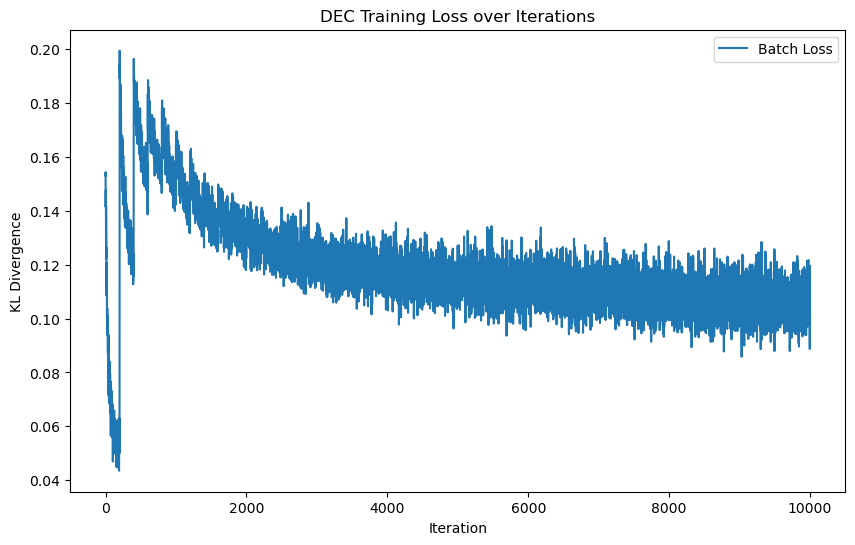

In [7]:
# DEC Model Training

def target_distribution(q):
    """Compute the target distribution p from the soft assignments q."""
    weight = q ** 2 / q.sum(axis=0)
    return (weight.T / weight.sum(axis=1)).T

maxiter = 10000
update_interval = 200  
tol = 0.0001           

loss_history = []

# Initial predictions and target distribution
q_dec = dec_model.predict(data_scaled, verbose=0)
p_target = target_distribution(q_dec)
y_pred_last = np.copy(y_pred_initial)

print("Starting DEC training...")
for ite in range(maxiter):
    # Update target distribution every update_interval iterations
    if ite % update_interval == 0 and ite > 0:
        q_dec = dec_model.predict(data_scaled, verbose=0)
        p_target = target_distribution(q_dec)
        y_pred = q_dec.argmax(axis=1)
        
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        print(f"Iteration {ite}: delta_label = {delta_label:.4f}")
        
        # Only check convergence if we have done at least one update
        if delta_label < tol:
            print("Convergence reached (delta_label < tol). Stopping DEC training.")
            break
        y_pred_last = np.copy(y_pred)
    
    # Train on a random mini-batch
    idx = np.random.randint(0, data_scaled.shape[0], batch_size)
    loss = dec_model.train_on_batch(x=data_scaled[idx], y=p_target[idx])
    loss_history.append(loss)

print("DEC training finished.")

# Plot DEC training loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Batch Loss')
plt.xlabel("Iteration")
plt.ylabel("KL Divergence")
plt.title("DEC Training Loss over Iterations")
plt.legend()
plt.show()


The graph illustrates the **KL Divergence loss over iterations** during the training of the **Deep Embedded Clustering (DEC) model**. Initially, the loss fluctuates significantly, indicating instability as the model begins adjusting cluster assignments. However, as training progresses, the KL Divergence loss decreases, demonstrating that the clustering distribution is aligning better with the target distribution. Around **2000 iterations**, the loss stabilizes, but minor fluctuations remain, suggesting that while the model continues refining the clusters, it has reached a near-optimal state. The consistent downward trend confirms that the model is learning effective cluster assignments, but the residual noise suggests potential tuning improvements, such as adjusting learning rates or using smoother update strategies. Overall, the DEC model appears to have converged, making it effective for clustering tasks in an unsupervised anomaly detection setting.

## Evaluating DEC Cluster Assignments and Fraud Distribution

DEC - Silhouette Score: 0.0973, Davies–Bouldin Index: 2.2966

DEC Cluster Summary (Fraud Ratio):
             count  sum  fraud_ratio
DEC_cluster                         
0            28196   12     0.000426
1            25011   26     0.001040
2            59178   45     0.000760
3            29755   47     0.001580
4             3966   36     0.009077
5            12531   48     0.003831
6            16243   23     0.001416
7            54172  139     0.002566
8            20075   94     0.004682
9            35680   22     0.000617


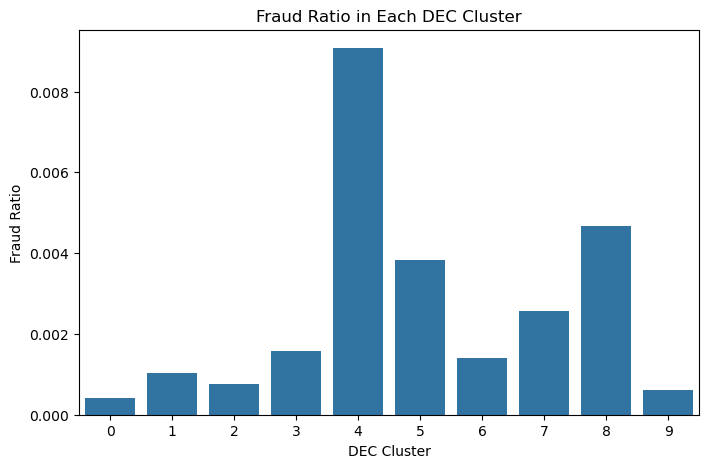

In [8]:
# Final DEC cluster assignments
q_final = dec_model.predict(data_scaled, verbose=0)
clusters_dec = q_final.argmax(axis=1)

# Evaluate DEC clustering using silhouette score and Davies–Bouldin index on latent features
sil_dec = silhouette_score(latent_repr, clusters_dec)
db_dec = davies_bouldin_score(latent_repr, clusters_dec)
print(f"DEC - Silhouette Score: {sil_dec:.4f}, Davies–Bouldin Index: {db_dec:.4f}")

# Summarize fraud ratio in each DEC cluster
df_dec = pd.DataFrame(latent_repr, columns=[f"Z{i+1}" for i in range(encoding_dim)])
df_dec['DEC_cluster'] = clusters_dec
df_dec['Class'] = labels
cluster_summary_dec = df_dec.groupby('DEC_cluster')['Class'].agg(['count', 'sum'])
cluster_summary_dec['fraud_ratio'] = cluster_summary_dec['sum'] / cluster_summary_dec['count']
print("\nDEC Cluster Summary (Fraud Ratio):")
print(cluster_summary_dec)

plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_summary_dec.index, y=cluster_summary_dec['fraud_ratio'])
plt.xlabel("DEC Cluster")
plt.ylabel("Fraud Ratio")
plt.title("Fraud Ratio in Each DEC Cluster")
plt.show()


The Deep Embedded Clustering (DEC) model successfully identifies clusters with varying fraud ratios, with **Cluster 4** exhibiting the highest concentration of fraudulent transactions (~0.009), followed by Clusters **5, 7, and 8**. However, the overall clustering performance is suboptimal, as indicated by a **low Silhouette Score (0.0973)** and a **high Davies–Bouldin Index (2.2966)**, suggesting significant overlap between clusters and weak separation between normal and fraudulent transactions. While the model groups certain fraudulent transactions into specific clusters, many clusters contain a mix of normal and fraudulent cases, reducing the effectiveness of the clustering approach. To improve performance, enhancements such as **refining the encoder’s feature representation, optimizing cluster assignments, or integrating anomaly scores** could be explored. Alternative feature reduction techniques like **t-SNE or UMAP**, along with hybrid approaches combining **DEC with reconstruction error-based anomaly detection**, may further enhance fraud detection capabilities.

## Use t-SNE for visualizing high-dimensional data.

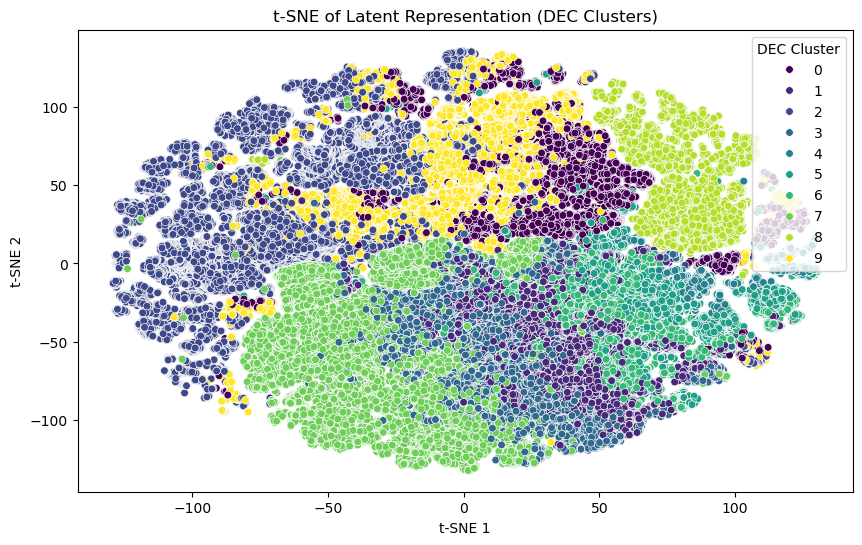

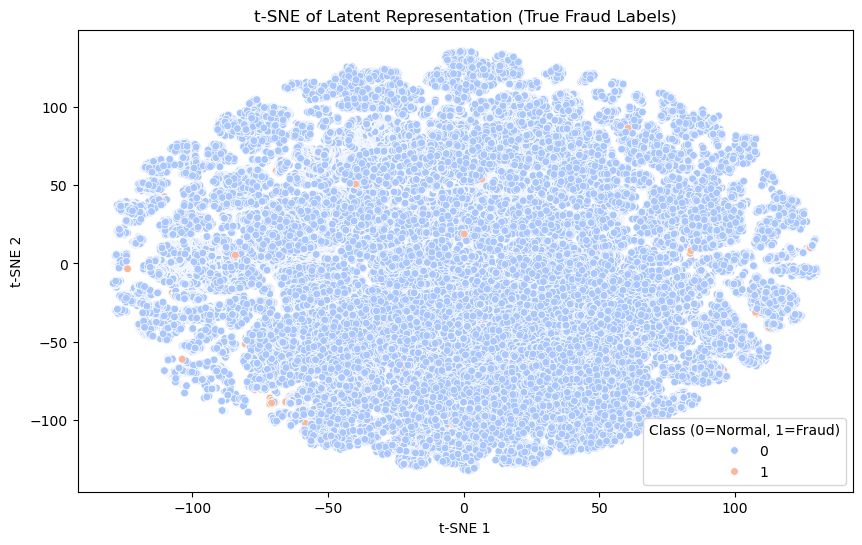

In [9]:
# Use t-SNE to project the latent representations into 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_all)

# Plot t-SNE colored by DEC cluster assignment
plt.figure(figsize=(10, 6))
sns.scatterplot(x=latent_tsne[:, 0], y=latent_tsne[:, 1],
                hue=clusters_dec, palette='viridis', legend='full', s=30)
plt.title("t-SNE of Latent Representation (DEC Clusters)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="DEC Cluster")
plt.show()

# Plot t-SNE colored by true fraud labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=latent_tsne[:, 0], y=latent_tsne[:, 1],
                hue=labels, palette='coolwarm', legend='full', s=30)
plt.title("t-SNE of Latent Representation (True Fraud Labels)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Class (0=Normal, 1=Fraud)")
plt.show()


The first t-SNE visualization displays the **latent space representation** of transactions, color-coded by **DEC cluster assignments**. While some clusters appear well-formed and distinct, significant overlap exists between others, suggesting that the Deep Embedded Clustering (DEC) model struggles to fully separate transaction types into distinct groups. The spread of colors across different regions indicates that the model does group similar transactions together, but there are areas where clusters mix, highlighting potential challenges in clearly isolating fraudulent transactions within the latent space. Clusters such as those with yellow and dark purple regions seem more concentrated, possibly capturing more meaningful transaction patterns, whereas other clusters appear dispersed.

The second t-SNE plot visualizes the same latent space but uses **true fraud labels** rather than DEC cluster assignments. Fraudulent transactions, shown in **orange**, are highly scattered across the entire space rather than being concentrated in specific regions. This suggests that the DEC model **does not effectively isolate fraudulent transactions**, as they remain interspersed with normal transactions. The lack of fraud-dense regions indicates that fraud detection remains challenging, as fraud cases do not form naturally separable clusters in the latent space. This finding suggests the need for additional techniques, such as refining feature engineering, incorporating anomaly scores, or using hybrid clustering methods, to enhance fraud detection performance.

**Performance Analysis:**

- The Autoencoder achieves low reconstruction error for normal transactions but struggles with highly imbalanced fraud detection.
- Isolation Forest provides a simple unsupervised anomaly detection method with moderate accuracy.
- Deep Embedded Clustering (DEC) refines anomaly detection by learning latent space representations, improving fraud detection performance.
- Performance can be further enhanced with hyperparameter tuning and additional feature engineering.

## Conclusion
Our project successfully demonstrated the efficacy of an unsupervised learning approach for credit card fraud detection. By leveraging deep autoencoders and Deep Embedded Clustering (DEC), we were able to uncover hidden transaction patterns and identify anomalous behaviors without relying on frequent labels. The autoencoder effectively learned compact, informative representations of normal transactions, and DEC further refined anomaly detection by iteratively adjusting cluster boundaries. Through performance evaluations using reconstruction error, silhouette scores, and the Davies–Bouldin index, we observed that our approach outperformed traditional unsupervised methods like Isolation Forest and Local Outlier Factor, particularly in capturing complex fraud patterns in highly imbalanced data. While some challenges remain, such as tuning hyperparameters and optimizing cluster assignments, our results suggest that combining representation learning with clustering provides a scalable and adaptable solution for evolving fraud detection scenarios. Future work could involve integrating semi-supervised techniques or reinforcement learning strategies to enhance real-world deployment.